In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import pickle
import requests
import json
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly as py
from plotly.graph_objs import *
from flask import Flask
import numpy as np
import pandas as pd
import os
from datetime import datetime as dt
import json
import plotly.graph_objs as go
from sklearn.metrics import confusion_matrix, f1_score

%matplotlib inline

In [2]:
data = pd.read_csv('cassandra.csv', sep = '\t')

In [3]:
data.head()

,time,GX,GY,GZ
0,1563310860000,-1.26,0.065000,-1.195000
1,1563310920000,-1.40,0.200000,-1.240000
2,1563310980000,-1.33,0.130000,-1.325000
3,1563311040000,-1.30,0.110000,-1.300000
4,1563311100000,-1.02,-0.073333,-1.436667


In [4]:
data.describe()

,time,GX,GY,GZ
count,1.943900e+04,19439.000000,19439.000000,19439.000000
mean,1.563894e+12,-1.300635,0.050662,-1.270023
std,3.367020e+08,0.107775,0.094775,0.113985
min,1.563311e+12,-1.760000,-0.634722,-1.707376
25%,1.563602e+12,-1.370000,-0.009350,-1.353623
50%,1.563894e+12,-1.305385,0.071388,-1.286667
75%,1.564186e+12,-1.240000,0.096826,-1.190000
max,1.564477e+12,-0.690000,0.520000,-0.790000


In [5]:
data.dtypes

time      int64
GX      float64
GY      float64
GZ      float64
dtype: object

In [6]:
number_features = len(data.columns)

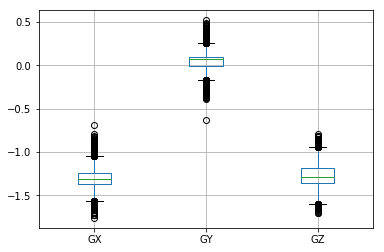

In [7]:
boxplot = data.boxplot(column=['GX', 'GY', 'GZ'])

# Feature Engineering 

The boxplot above clearly shows some outliers. The next step is to find the most important features for us to consider for the model. In this case, we will have to come up with some extra columns.


In [8]:
data['GX_Error'] = np.where((data['GX'] < -1.6) | (data['GX'] > -1), 1, 0 )
data['GY_Error'] = np.where((data['GY'] < -0.25) | (data['GY'] > 0.25), 1, 0 )
data['GZ_Error'] = np.where((data['GZ'] < -1.5) | (data['GZ'] > -0.8), 1, 0 )
data['Error'] = np.where((data['GX_Error'] == 1) | (data['GY_Error'] == 1)| (data['GZ_Error'] == 1), 1, 0 )
data.head(10)

,time,GX,GY,GZ,GX_Error,GY_Error,GZ_Error,Error
0,1563310860000,-1.260000,0.065000,-1.195000,0,0,0,0
1,1563310920000,-1.400000,0.200000,-1.240000,0,0,0,0
2,1563310980000,-1.330000,0.130000,-1.325000,0,0,0,0
3,1563311040000,-1.300000,0.110000,-1.300000,0,0,0,0
4,1563311100000,-1.020000,-0.073333,-1.436667,0,0,0,0
5,1563311160000,-1.363333,-0.016667,-1.350000,0,0,0,0
6,1563311220000,-1.225000,0.095000,-1.210000,0,0,0,0
7,1563311280000,-1.130000,0.120000,-1.200000,0,0,0,0
8,1563311340000,-0.980000,-0.020000,-1.280000,1,0,0,1
9,1563311400000,-1.120000,0.020000,-1.200000,0,0,0,0


# Getting X and Y values

In [9]:
# Target variables
y = data['Error'].values

#Attribute variable

data = data.drop(['Error', 'GX_Error','GY_Error', 'GZ_Error' ], axis=1)
X = data.values


In [10]:
pca=PCA(n_components=number_features)                                    
pca.fit(X) 

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# Cumulative sum of variance explained with features

In [11]:
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
variance

array([100., 100., 100., 100.])

In [12]:
pca = PCA(n_components=4)
X_r = pca.fit(X).transform(X)

logistic = linear_model.LogisticRegression()
pipeline = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
pipeline.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [15]:
pipeline.score(X_test, y_test)

0.5142318244170097

# Saving the model

In [16]:
filename = 'final_model.pkl'
pickle.dump(pipeline, open('final_model.pkl', 'wb'))

# The Application

In [17]:
services = os.getenv("VCAP_SERVICES")
port = None

if services is not None:
    vcap = json.loads(services)
    port = int(os.getenv("PORT"))

In [18]:
external_css = ["https://cdnjs.cloudflare.com/ajax/libs/skeleton/2.0.4/skeleton.min.css",
                "https://fonts.googleapis.com/css?family=Raleway:400,400i,700,700i",
                "https://fonts.googleapis.com/css?family=Product+Sans:400,400i,700,700i"]

app = dash.Dash(
    'streaming-SUMon-app',
    external_stylesheets=external_css
)
server = app.server

app.css.config.serve_locally = True
app.scripts.config.serve_locally = True

In [19]:
df = pd.read_csv('cassandra10s.csv', sep = '\t')

In [20]:
df['magnitude'] = np.sqrt((df['GX']**2 + df['GY']**2 + df['GY']**3))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in sqrt



In [21]:
df.head()

,time,GX,GY,GZ,magnitude
0,1563310810000,-1.280000,0.030000,-1.146,1.280362
1,1563310820000,-1.400000,-0.013333,-1.210,1.400063
2,1563310830000,-1.300000,-0.020000,-1.110,1.300151
3,1563310840000,-1.316667,0.066667,-1.190,1.318466
4,1563310850000,-1.050000,0.040000,-1.220,1.050792


In [22]:
df['time'] = pd.to_datetime(df['time'], unit = 'ms')

In [23]:
# dropdown options from the dataframe
features = df.columns[1:4]
opts = [{'label' : i, 'value' : i} for i in features]

In [24]:
# Create a Dash layout


app.layout = html.Div([
                # a header and a paragraph
                html.Div([
                    html.H1("Turbine Dashboard"),],
                     style = {'padding' : '50px' ,
                              'backgroundColor' : '#3aaab2'}),
               
                # adding first anad second graph
                dcc.Graph(id = 'plot1'),
                dcc.Graph(id = 'plot2'),
               
                
                # dropdown
                html.P([
                    html.Label("Choose a Turbine"),
                    dcc.Dropdown(id = 'opt', options = opts,
                                value = opts[0])
                        ], style = {'width': '400px',
                                    'fontSize' : '20px',
                                    'padding-left' : '100px',
                                    'display': 'inline-block'}),
                             # adding third graph
             
            dcc.Graph(id = 'plot3'),
            
    
    
    ])


In [25]:
# populating the first graph
@app.callback(Output('plot1', 'figure'),
             [Input('opt', 'value')])

def update_figure1(value):
    trace_1 = go.Line(x = df.time, y = df['GX'],
                     name = 'GX',
                     line = dict(width = 5,
                                 color = 'Red'))
    trace_2 = go.Line(x = df.time, y = df['GY'],
                     name = 'GY',
                     line = dict(width = 5,
                                 color = 'yellow'))
    trace_3 = go.Line(x = df.time, y = df['GZ'],
                     name = 'GZ',
                     line = dict(width = 5,
                                 color = 'green'))
    layout = go.Layout(title = 'Time Series Plot for GX, GY and GZ',
                   hovermode = 'closest')
    fig = go.Figure(data = [trace_1, trace_2, trace_3], layout = layout)
    return fig
    

In [26]:
# populating the second graph
@app.callback(Output('plot2', 'figure'),
             [Input('opt', 'value')])

def update_figure2(value):
    trace = go.Scatter(x = df['time'], y = df['magnitude'],
                       name = 'magnitue',
                       line = dict(width = 2,
                                   color = 'blue'))
    layout = go.Layout(title = 'Magnitude',
                   hovermode = 'closest')
    fig = go.Figure(data = [trace], layout = layout)
    return fig
    

In [27]:
# populating the third graph
@app.callback(Output('plot3', 'figure'),
             [Input('opt', 'value')])

def update_figure3(figure):
    if 'opt' == 'GX':
        trace = go.Scatter(x = df['time'], y = df['GX'],
                       line = dict(width = 2,
                                   color = 'blue'))
        layout = go.Layout(title = '',
                   hovermode = 'closest')
        
        #fig = go.Figure(data = [trace], layout = layout)
     
    
    elif 'opt' == 'GY':
        trace = go.Scatter(x = df['time'], y = df['GY'],
                       line = dict(width = 2,
                                   color = 'yellow'))
        layout = go.Layout(hovermode = 'closest')
       
        #fig = go.Figure(data = [trace], layout = layout)
       
        
    else:
        trace = go.Scatter(x = df['time'], y = df['GZ'],
                       line = dict(width = 2,
                                   color = 'green'))
        
        layout = go.Layout(hovermode = 'closest')
       
        fig = go.Figure(data = [trace], layout = layout)
        
        return fig


In [28]:
if __name__ == '__main__':
    if port is not None:
        app.run_server(host='0.0.0.0', port=port)

    else:
        app.run_server()

 * Serving Flask app "streaming-SUMon-app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Oct/2019 21:09:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Oct/2019 21:09:57] "GET /_dash-component-suites/dash_core_components/highlight.pack.js?v=1.0.0&m=1563307603 HTTP/1.1" 200 -
127.0.0.1 - - [09/Oct/2019 21:09:57] "GET /_dash-component-suites/dash_renderer/dash_renderer.min.js?v=1.0.0&m=1561062262 HTTP/1.1" 200 -
127.0.0.1 - - [09/Oct/2019 21:09:57] "GET /_dash-component-suites/dash_renderer/prop-types@15.7.2.min.js?v=1.0.0&m=1561062262 HTTP/1.1" 200 -
127.0.0.1 - - [09/Oct/2019 21:09:57] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js?v=1.0.0&m=1561063963 HTTP/1.1" 200 -
127.0.0.1 - - [09/Oct/2019 21:09:57] "GET /_dash-component-suites/dash_renderer/react@16.8.6.min.js?v=1.0.0&m=1561062262 HTTP/1.1" 200 -
127.0.0.1 - - [09/Oct/2019 21:09:57] "GET /_dash-component-suites/dash_renderer/react-dom@16.8.6.min.js?v=1.0.0&m=1561062262 HTTP/1.1" 200 -
127.0.0.1 - - [09/Oct/2019 2